PARTE 1

In [1]:
import pandas as pd
import numpy as np

# 1. CARGA DE DATOS
ventas = pd.read_csv('transacciones_ventas.csv')
inventario = pd.read_csv('inventario_diario.csv')
maestro = pd.read_csv('maestro_productos.csv')

def clean_numeric(series):
    # Elimina ruido (símbolos, espacios) y convierte a numérico
    if series.dtype == 'O':
        return pd.to_numeric(series.astype(str).str.replace(r'[^\d.-]', '', regex=True), errors='coerce')
    return pd.to_numeric(series, errors='coerce')

# 2. LIMPIEZA DE CATEGORÍAS Y TIPOS
for df in [ventas, inventario, maestro]:
    if 'categoria' in df.columns:
        df['categoria'] = df['categoria'].astype(str).str.strip().str.title()

# Conversión numérica de columnas críticas
cols_ventas = ['unidades_vendidas', 'precio_unitario_venta', 'precio_lista_original', 'costo_unitario']
for col in cols_ventas:
    ventas[col] = clean_numeric(ventas[col])

inventario['valor_inventario_costo'] = clean_numeric(inventario['valor_inventario_costo'])
maestro['costo_unitario'] = clean_numeric(maestro['costo_unitario'])
maestro['precio_lista'] = clean_numeric(maestro['precio_lista'])

# 3. INTEGRACIÓN CON MAESTRO DE PRODUCTOS
# Usamos el maestro para rellenar costos o precios de lista faltantes en ventas
ventas_full = ventas.merge(maestro[['product_id', 'costo_unitario', 'precio_lista']], 
                           on='product_id', how='left', suffixes=('_v', '_m'))

# Lógica de fallback
ventas_full['costo_final'] = ventas_full['costo_unitario_v'].fillna(ventas_full['costo_unitario_m'])
ventas_full['precio_lista_final'] = ventas_full['precio_lista_original'].fillna(ventas_full['precio_lista'])

# 4. CÁLCULO DE MÉTRICAS
ventas_full['utilidad_bruta'] = ventas_full['unidades_vendidas'] * (ventas_full['precio_unitario_venta'] - ventas_full['costo_final'])
ventas_full['ingreso_real'] = ventas_full['unidades_vendidas'] * ventas_full['precio_unitario_venta']
ventas_full['ingreso_potencial'] = ventas_full['unidades_vendidas'] * ventas_full['precio_lista_final']

# Agrupación por categoría (filtrando valores nulos de categoría)
ventas_full = ventas_full[ventas_full['categoria'] != 'Nan']
cat_stats = ventas_full.groupby('categoria').agg({
    'utilidad_bruta': 'sum',
    'ingreso_real': 'sum',
    'ingreso_potencial': 'sum'
}).reset_index()

# Inventario promedio a costo
cat_inv = inventario[inventario['categoria'] != 'Nan'].groupby('categoria')['valor_inventario_costo'].mean().reset_index()
cat_inv.columns = ['categoria', 'inv_promedio_costo']

# 5. RESULTADOS FINALES (GMROI y Markdown)
df_final = cat_stats.merge(cat_inv, on='categoria')
df_final['GMROI'] = df_final['utilidad_bruta'] / df_final['inv_promedio_costo']
df_final['Markdown_Pct'] = (1 - (df_final['ingreso_real'] / df_final['ingreso_potencial'])) * 100

print(df_final[['categoria', 'GMROI', 'Markdown_Pct']].sort_values(by='GMROI', ascending=False).head(10))

                      categoria      GMROI  Markdown_Pct
137                       Hogar  94.049948      6.983152
229                   Relojería  86.077190      4.746089
58                       Carnes  84.140954      5.391397
151                 Informática  81.553854      6.693066
196                     Muebles  81.403035      3.758732
240                 Ropa Hombre  80.933400      5.923863
86                     Deportes  80.854814      9.166626
20                   Automotriz  79.969620      5.207047
216  Pequeños Electrodomésticos  79.892662      4.808126
180                     Lácteos  79.524157      6.643881


PARTE 2

In [14]:
import asyncio
import statistics
import concurrent.futures
import nest_asyncio
from playwright.sync_api import sync_playwright

nest_asyncio.apply()

def proceso_scraping_completo():

    def scrape_tipo(p_context, tipo):
        print(f"\n--- Extrayendo {tipo.upper()} en Huechuraba ---")
        results = []
        browser = p_context.chromium.launch(headless=False)
        page = browser.new_page()
        url = f"https://www.portalinmobiliario.cl/venta/{tipo}/huechuraba-metropolitana"
        
        try:
            page.goto(url, wait_until="domcontentloaded", timeout=60000)
            pagina = 1
            while True:
                print(f"Procesando página {pagina}...")
                page.wait_for_timeout(2000)
                page.mouse.wheel(0, 3000)
                page.wait_for_timeout(1000)

                items = page.query_selector_all(".ui-search-result__wrapper")
                for item in items:
                    try:
                        # 1. Obtener el Precio
                        p_elem = item.query_selector(".andes-money-amount__fraction")
                        # 2. Obtener la Moneda
                        currency_elem = item.query_selector(".andes-money-amount__currency-symbol")
                        currency = currency_elem.inner_text() if currency_elem else ""
                        
                        card_text = item.inner_text()
                        m2_val = None
                        if "m²" in card_text:
                            parts = card_text.split()
                            for i, part in enumerate(parts):
                                if "m²" in part and i > 0:
                                    try:
                                        m2_val = float(parts[i-1].replace('.', '').replace(',', '.'))
                                        break
                                    except: continue
                        
                        if p_elem and m2_val and "UF" in currency:
                            price = float(p_elem.inner_text().replace('.', ''))
                            # Filtro de seguridad por precio
                            if 1000 < price < 100000: 
                                results.append({"p": price, "m": m2_val})
                    except: continue

                # Lógica de paginación para que simulemos que estamos visitando cada pagina y no nos bloquee la WAF
                next_btn = page.query_selector('a[title="Siguiente"]')
                if next_btn and next_btn.is_visible():
                    next_btn.click()
                    pagina += 1
                    page.wait_for_load_state("domcontentloaded")
                else:
                    break
        except Exception as e:
            print(f"Fin de navegación o error: {e}")
        finally:
            browser.close()
        return results

    # Ejecución
    with sync_playwright() as p:
        c_data = scrape_tipo(p, "casa")
        d_data = scrape_tipo(p, "departamento")

    return c_data, d_data

async def realizar_tarea_final():
    # Ejecutamos en un pool para evitar el NotImplementedError y el error de Loop
    loop = asyncio.get_event_loop()
    with concurrent.futures.ThreadPoolExecutor() as pool:
        c_data, d_data = await loop.run_in_executor(pool, proceso_scraping_completo)

    def get_stats(lista):
        if not lista: return [0, 0, 0, 0]
        precios = [x['p'] for x in lista]
        uf_m2 = [x['p']/x['m'] for x in lista if x['m'] > 0]
        return [len(lista), statistics.median(precios), statistics.mean(precios), statistics.mean(uf_m2)]

    c, d = get_stats(c_data), get_stats(d_data)

    print("\n" + "="*65)
    print(f"{'Métrica':<35} | {'Casas':<12} | {'Deptos':<12}")
    print("-" * 65)
    print(f"{'Propiedades filtradas (#)':<35} | {c[0]:<12.0f} | {d[0]:<12.0f}")
    print(f"{'Mediana precio (UF)':<35} | {c[1]:<12.0f} | {d[1]:<12.0f}")
    print(f"{'Promedio precio (UF)':<35} | {c[2]:<12.0f} | {d[2]:<12.0f}")
    print(f"{'Precio por m2 (UF/m2)':<35} | {c[3]:<12.2f} | {d[3]:<12.2f}")
    print("="*65)

# Lanzar
await realizar_tarea_final()


--- Extrayendo CASA en Huechuraba ---
Procesando página 1...
Procesando página 2...
Procesando página 3...
Procesando página 4...
Procesando página 5...
Procesando página 6...
Procesando página 7...
Procesando página 8...
Procesando página 9...
Procesando página 10...
Procesando página 11...
Procesando página 12...
Procesando página 13...
Procesando página 14...
Procesando página 15...
Procesando página 16...

--- Extrayendo DEPARTAMENTO en Huechuraba ---
Procesando página 1...
Procesando página 2...
Procesando página 3...
Procesando página 4...
Procesando página 5...
Procesando página 6...
Procesando página 7...
Procesando página 8...
Procesando página 9...
Procesando página 10...
Procesando página 11...

Métrica                             | Casas        | Deptos      
-----------------------------------------------------------------
Propiedades filtradas (#)           | 682          | 494         
Mediana precio (UF)                 | 8700         | 5725        
Promedio precio (UF

TERCERA PARTE

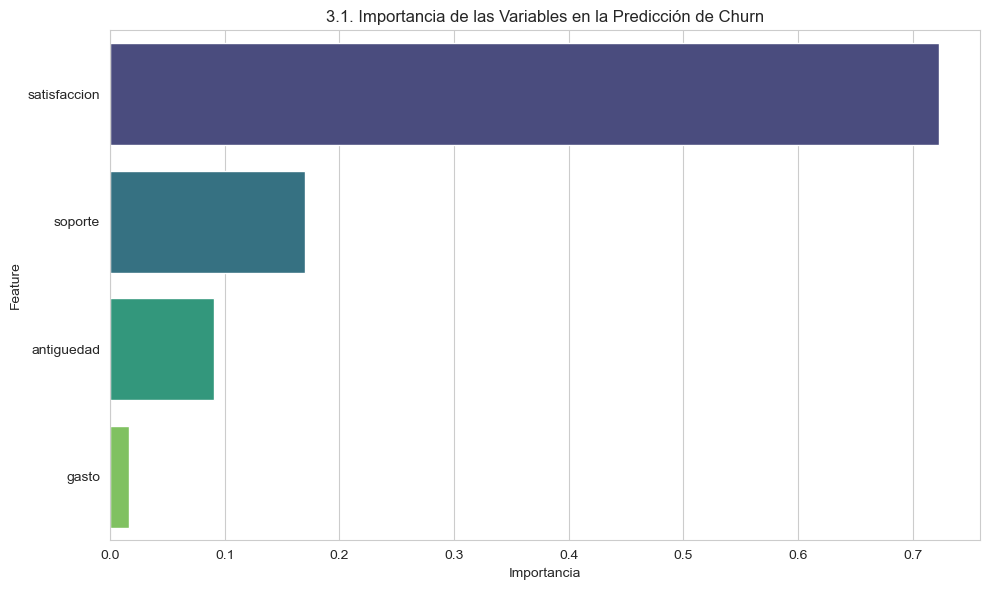

=== 3.1. REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     30034
           1       0.83      0.31      0.46      5066

    accuracy                           0.89     35100
   macro avg       0.86      0.65      0.70     35100
weighted avg       0.89      0.89      0.87     35100


=== 3.2. TABLA DE LIFT Y GANANCIA (10 DECILES) ===
       Clientes  Churners_Encontrados      Lift  Ganancia_Acumulada_%
Decil                                                                
1          3510                  2385  4.707856             47.078563
2          3510                  1505  2.970786             76.786419
3          3510                   577  1.138966             88.176076
4          3510                   236  0.465851             92.834583
5          3510                    59  0.116463             93.999210
6          3510                    58  0.114489             95.144098
7          3510        

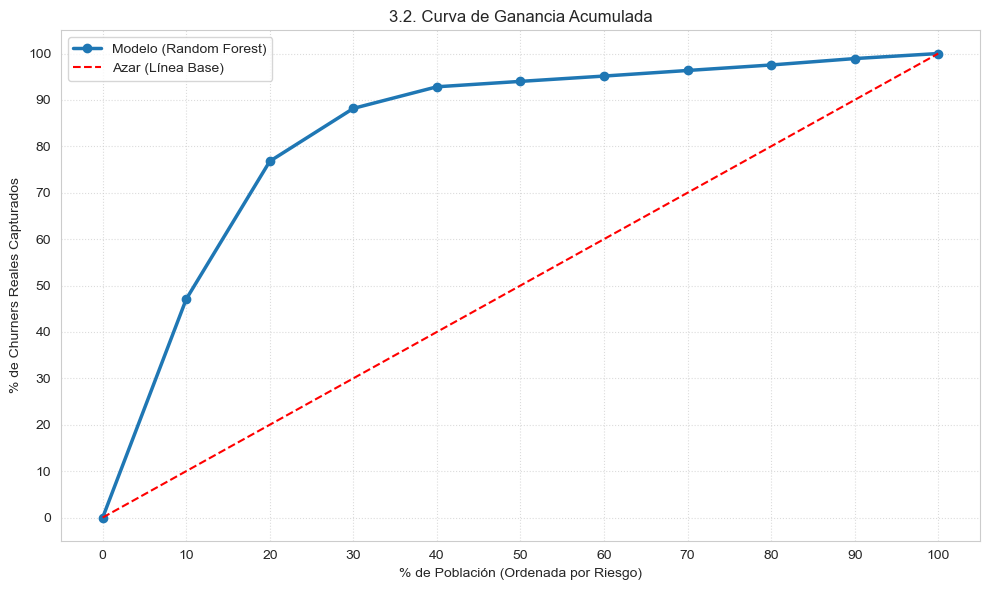

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Carga de datos
df = pd.read_csv('data_churn.csv')
X = df.drop('churn_real', axis=1)
y = df['churn_real']

# 2. División de datos (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ==========================================
# 3.1. Entrenamiento e Importancia de Variables
# ==========================================
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Cálculo de importancia
importancias = pd.DataFrame({
    'Feature': X.columns,
    'Importancia': model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Gráfico de Importancia (Corregido para evitar el Warning)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=importancias, hue='Feature', palette='viridis', legend=False)
plt.title('3.1. Importancia de las Variables en la Predicción de Churn')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("=== 3.1. REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, model.predict(X_test)))

# ==========================================
# 3.2. Análisis de Lift y Ganancia (10 Deciles)
# ==========================================
y_probs = model.predict_proba(X_test)[:, 1]
lift_df = pd.DataFrame({'Actual': y_test, 'Probabilidad': y_probs})
lift_df = lift_df.sort_values(by='Probabilidad', ascending=False).reset_index(drop=True)

# Creación de 10 deciles
lift_df['Decil'] = pd.qcut(lift_df['Probabilidad'].rank(method='first'), 10, labels=False)
lift_df['Decil'] = 10 - lift_df['Decil']

# Métricas por decil
total_churners = lift_df['Actual'].sum()
tasa_global = lift_df['Actual'].mean()

resumen_lift = lift_df.groupby('Decil').agg(
    Clientes=('Actual', 'count'),
    Churners_Encontrados=('Actual', 'sum')
)

resumen_lift['Lift'] = (resumen_lift['Churners_Encontrados'] / resumen_lift['Clientes']) / tasa_global
resumen_lift['Ganancia_Acumulada_%'] = (resumen_lift['Churners_Encontrados'].cumsum() / total_churners) * 100

print("\n=== 3.2. TABLA DE LIFT Y GANANCIA (10 DECILES) ===")
print(resumen_lift[['Clientes', 'Churners_Encontrados', 'Lift', 'Ganancia_Acumulada_%']])

# Gráfico de Curva de Ganancia
plt.figure(figsize=(10, 6))
x_axis = np.arange(0, 110, 10)
y_axis = np.concatenate(([0], resumen_lift['Ganancia_Acumulada_%'].values))

plt.plot(x_axis, y_axis, marker='o', color='#1f77b4', linewidth=2.5, label='Modelo (Random Forest)')
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Azar (Línea Base)')

plt.title('3.2. Curva de Ganancia Acumulada')
plt.xlabel('% de Población (Ordenada por Riesgo)')
plt.ylabel('% de Churners Reales Capturados')
plt.xticks(x_axis)
plt.yticks(np.arange(0, 110, 10))
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

PARTE 4

--- Parámetros Gamma-Gamma: p=0.9749, q=6.4411, v=339.2870 ---
--- R2 Regresión Lineal: 0.8896 ---



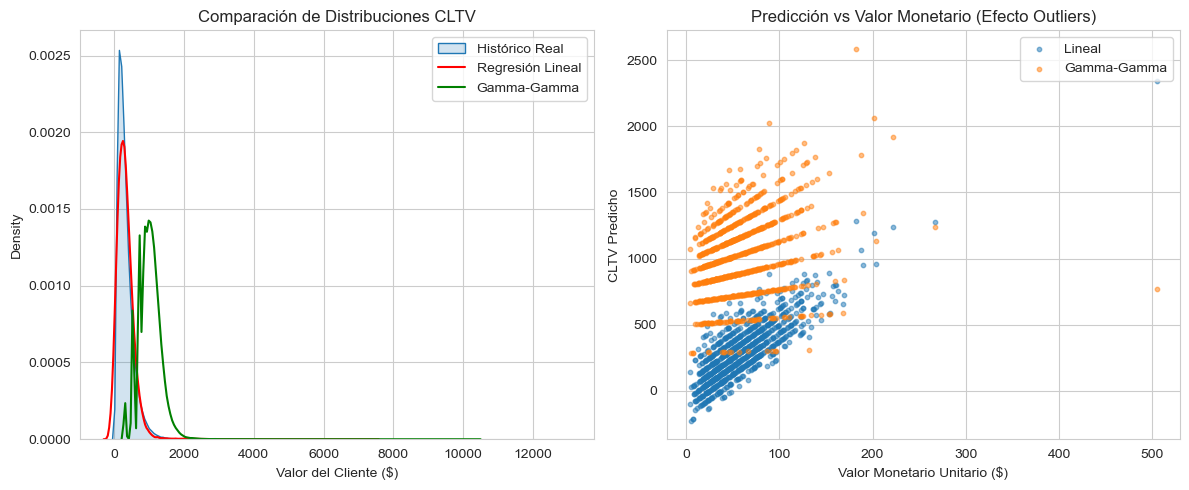

--- Comparación en Clientes con Gasto Extremo (Outliers) ---
        frequency  monetary_value  cltv_historico  cltv_pred_linear  \
93000           6         1488.06         8928.36       7516.839609   
136700          3         1302.73         3908.19       6400.789689   
21800           4         1294.96         5179.84       6424.387319   
79800           5         1207.83         6039.15       6050.402520   
57000          13         1000.62        13008.06       5512.503477   

        cltv_pred_gg  
93000    5606.701252  
136700   2028.337285  
21800    2953.080156  
79800    3748.546560  
57000   10425.732458  


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.special import gammaln
from scipy.optimize import minimize

# Configuración visual
sns.set_style("whitegrid")

# 1. CARGA Y LIMPIEZA DE DATOS
df_rfm = pd.read_csv('data_rfm_cltv.csv')

# El modelo Gamma-Gamma requiere frecuencia > 0 (clientes con al menos una recompra)
df_rfm = df_rfm[df_rfm['frequency'] > 0].copy()

# Target real para comparación (Valor Monetario Histórico Total)
df_rfm['cltv_historico'] = df_rfm['frequency'] * df_rfm['monetary_value']

# ==========================================
# 4.1. MODELADO DE CLTV
# ==========================================

# --- A. Regresión Lineal ---
X_lin = df_rfm[['frequency', 'monetary_value']]
y_lin = df_rfm['cltv_historico']

model_lin = LinearRegression()
model_lin.fit(X_lin, y_lin)
df_rfm['cltv_pred_linear'] = model_lin.predict(X_lin)

# --- B. Modelo Gamma-Gamma (Implementación Manual) ---
def gamma_gamma_log_likelihood(params, frequency, monetary_value):
    p, q, v = params
    if p <= 0 or q <= 0 or v <= 0: return 1e10
    x, m = frequency, monetary_value
    # Log-verosimilitud del modelo Gamma-Gamma
    ll = (gammaln(p*x + q) - gammaln(p*x) - gammaln(q) + 
          q*np.log(v) + p*x*np.log(p*x) + (p*x-1)*np.log(m) - 
          (p*x+q)*np.log(v + m*p*x))
    return -np.sum(ll)

# Optimización de parámetros p, q, v
res = minimize(gamma_gamma_log_likelihood, [2.0, 2.0, 10.0], 
               args=(df_rfm['frequency'].values, df_rfm['monetary_value'].values),
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
p, q, v = res.x

# Función de Valor Monetario Esperado (Expected Average Profit)
def expected_avg_profit(p, q, v, x, m):
    return ((q - 1) * v + m * x * p) / (p * x + q - 1)

df_rfm['monetario_esperado_gg'] = expected_avg_profit(p, q, v, df_rfm['frequency'], df_rfm['monetary_value'])
df_rfm['cltv_pred_gg'] = df_rfm['monetario_esperado_gg'] * df_rfm['frequency']

print(f"--- Parámetros Gamma-Gamma: p={p:.4f}, q={q:.4f}, v={v:.4f} ---")
print(f"--- R2 Regresión Lineal: {model_lin.score(X_lin, y_lin):.4f} ---\n")

# ==========================================
# VISUALIZACIÓN Y COMPARACIÓN
# ==========================================

plt.figure(figsize=(12, 5))

# Gráfico 1: Distribución de Predicciones
plt.subplot(1, 2, 1)
sns.kdeplot(df_rfm['cltv_historico'], label='Histórico Real', fill=True, alpha=0.2)
sns.kdeplot(df_rfm['cltv_pred_linear'], label='Regresión Lineal', color='red')
sns.kdeplot(df_rfm['cltv_pred_gg'], label='Gamma-Gamma', color='green')
plt.title('Comparación de Distribuciones CLTV')
plt.xlabel('Valor del Cliente ($)')
plt.legend()

# Gráfico 2: Efecto Outliers (Shrinkage)
plt.subplot(1, 2, 2)
# Tomamos una muestra para que el gráfico sea legible
sample = df_rfm.sample(1000, random_state=42)
plt.scatter(sample['monetary_value'], sample['cltv_pred_linear'], alpha=0.5, label='Lineal', s=10)
plt.scatter(sample['monetary_value'], sample['cltv_pred_gg'], alpha=0.5, label='Gamma-Gamma', s=10)
plt.title('Predicción vs Valor Monetario (Efecto Outliers)')
plt.xlabel('Valor Monetario Unitario ($)')
plt.ylabel('CLTV Predicho')
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================
# 4.2. ANÁLISIS DE ROBUSTEZ (EJEMPLO OUTLIERS)
# ==========================================
outliers = df_rfm.nlargest(5, 'monetary_value')
print("--- Comparación en Clientes con Gasto Extremo (Outliers) ---")
print(outliers[['frequency', 'monetary_value', 'cltv_historico', 'cltv_pred_linear', 'cltv_pred_gg']])

PARTE 5

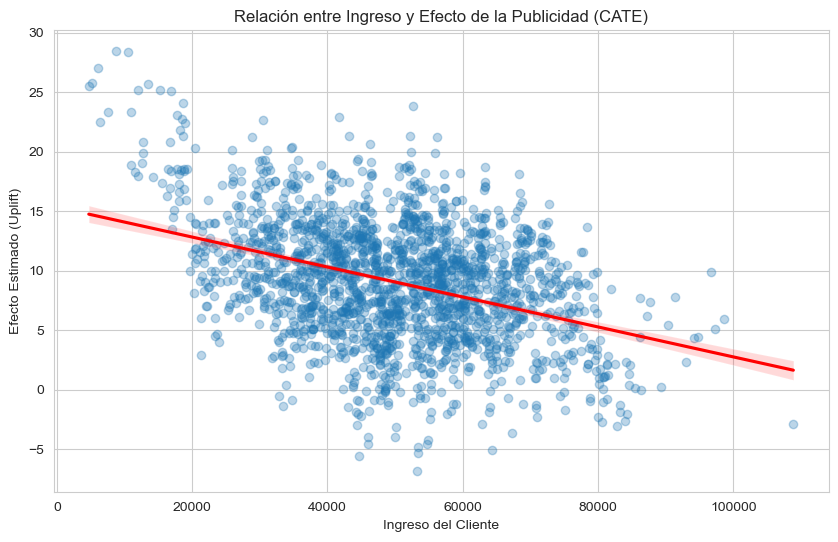

Correlación entre Ingreso y CATE: -0.3815


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# 1. Cargar datos
df_causal = pd.read_csv('data_inferencia_causal.csv')

# Variables: X = [edad, ingreso], W = Tratamiento, Y = Resultado
X = df_causal[['edad', 'ingreso']]
W = df_causal['W']
Y = df_causal['Y']

# --- A. S-Learner (Single Learner) ---
# Entrena un solo modelo incluyendo W como una característica más
X_s = df_causal[['edad', 'ingreso', 'W']]
s_learner = RandomForestRegressor(n_estimators=100, random_state=42)
s_learner.fit(X_s, Y)

# Calculamos la diferencia entre predecir con W=1 y W=0
df_w1 = X_s.copy(); df_w1['W'] = 1
df_w0 = X_s.copy(); df_w0['W'] = 0
cate_s = s_learner.predict(df_w1) - s_learner.predict(df_w0)

# --- B. T-Learner (Two Learner) ---
# Entrena dos modelos separados: uno para tratados y otro para control
m0 = RandomForestRegressor(n_estimators=100, random_state=42)
m1 = RandomForestRegressor(n_estimators=100, random_state=42)

m0.fit(X[W == 0], Y[W == 0])
m1.fit(X[W == 1], Y[W == 1])

cate_t = m1.predict(X) - m0.predict(X)

# Guardar resultados
df_causal['cate_s'] = cate_s
df_causal['cate_t'] = cate_t

# 2. Visualización del CATE vs Ingreso
plt.figure(figsize=(10, 6))
sns.regplot(x='ingreso', y='cate_t', data=df_causal, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relación entre Ingreso y Efecto de la Publicidad (CATE)')
plt.xlabel('Ingreso del Cliente')
plt.ylabel('Efecto Estimado (Uplift)')
plt.show()

# Calcular correlación para el punto 5.2
corr_ingreso = df_causal['ingreso'].corr(df_causal['cate_t'])
print(f"Correlación entre Ingreso y CATE: {corr_ingreso:.4f}")